<a href="https://colab.research.google.com/github/XuZhaozhong-1/Xzz/blob/main/Lab_427_Zhaozhong_Xu5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab 5 Report:
## Create Arthur Conan Doyle AI with RNN

### Name:

In [57]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical
import tqdm

In [58]:
from IPython.display import Image # For displaying images in colab jupyter cell

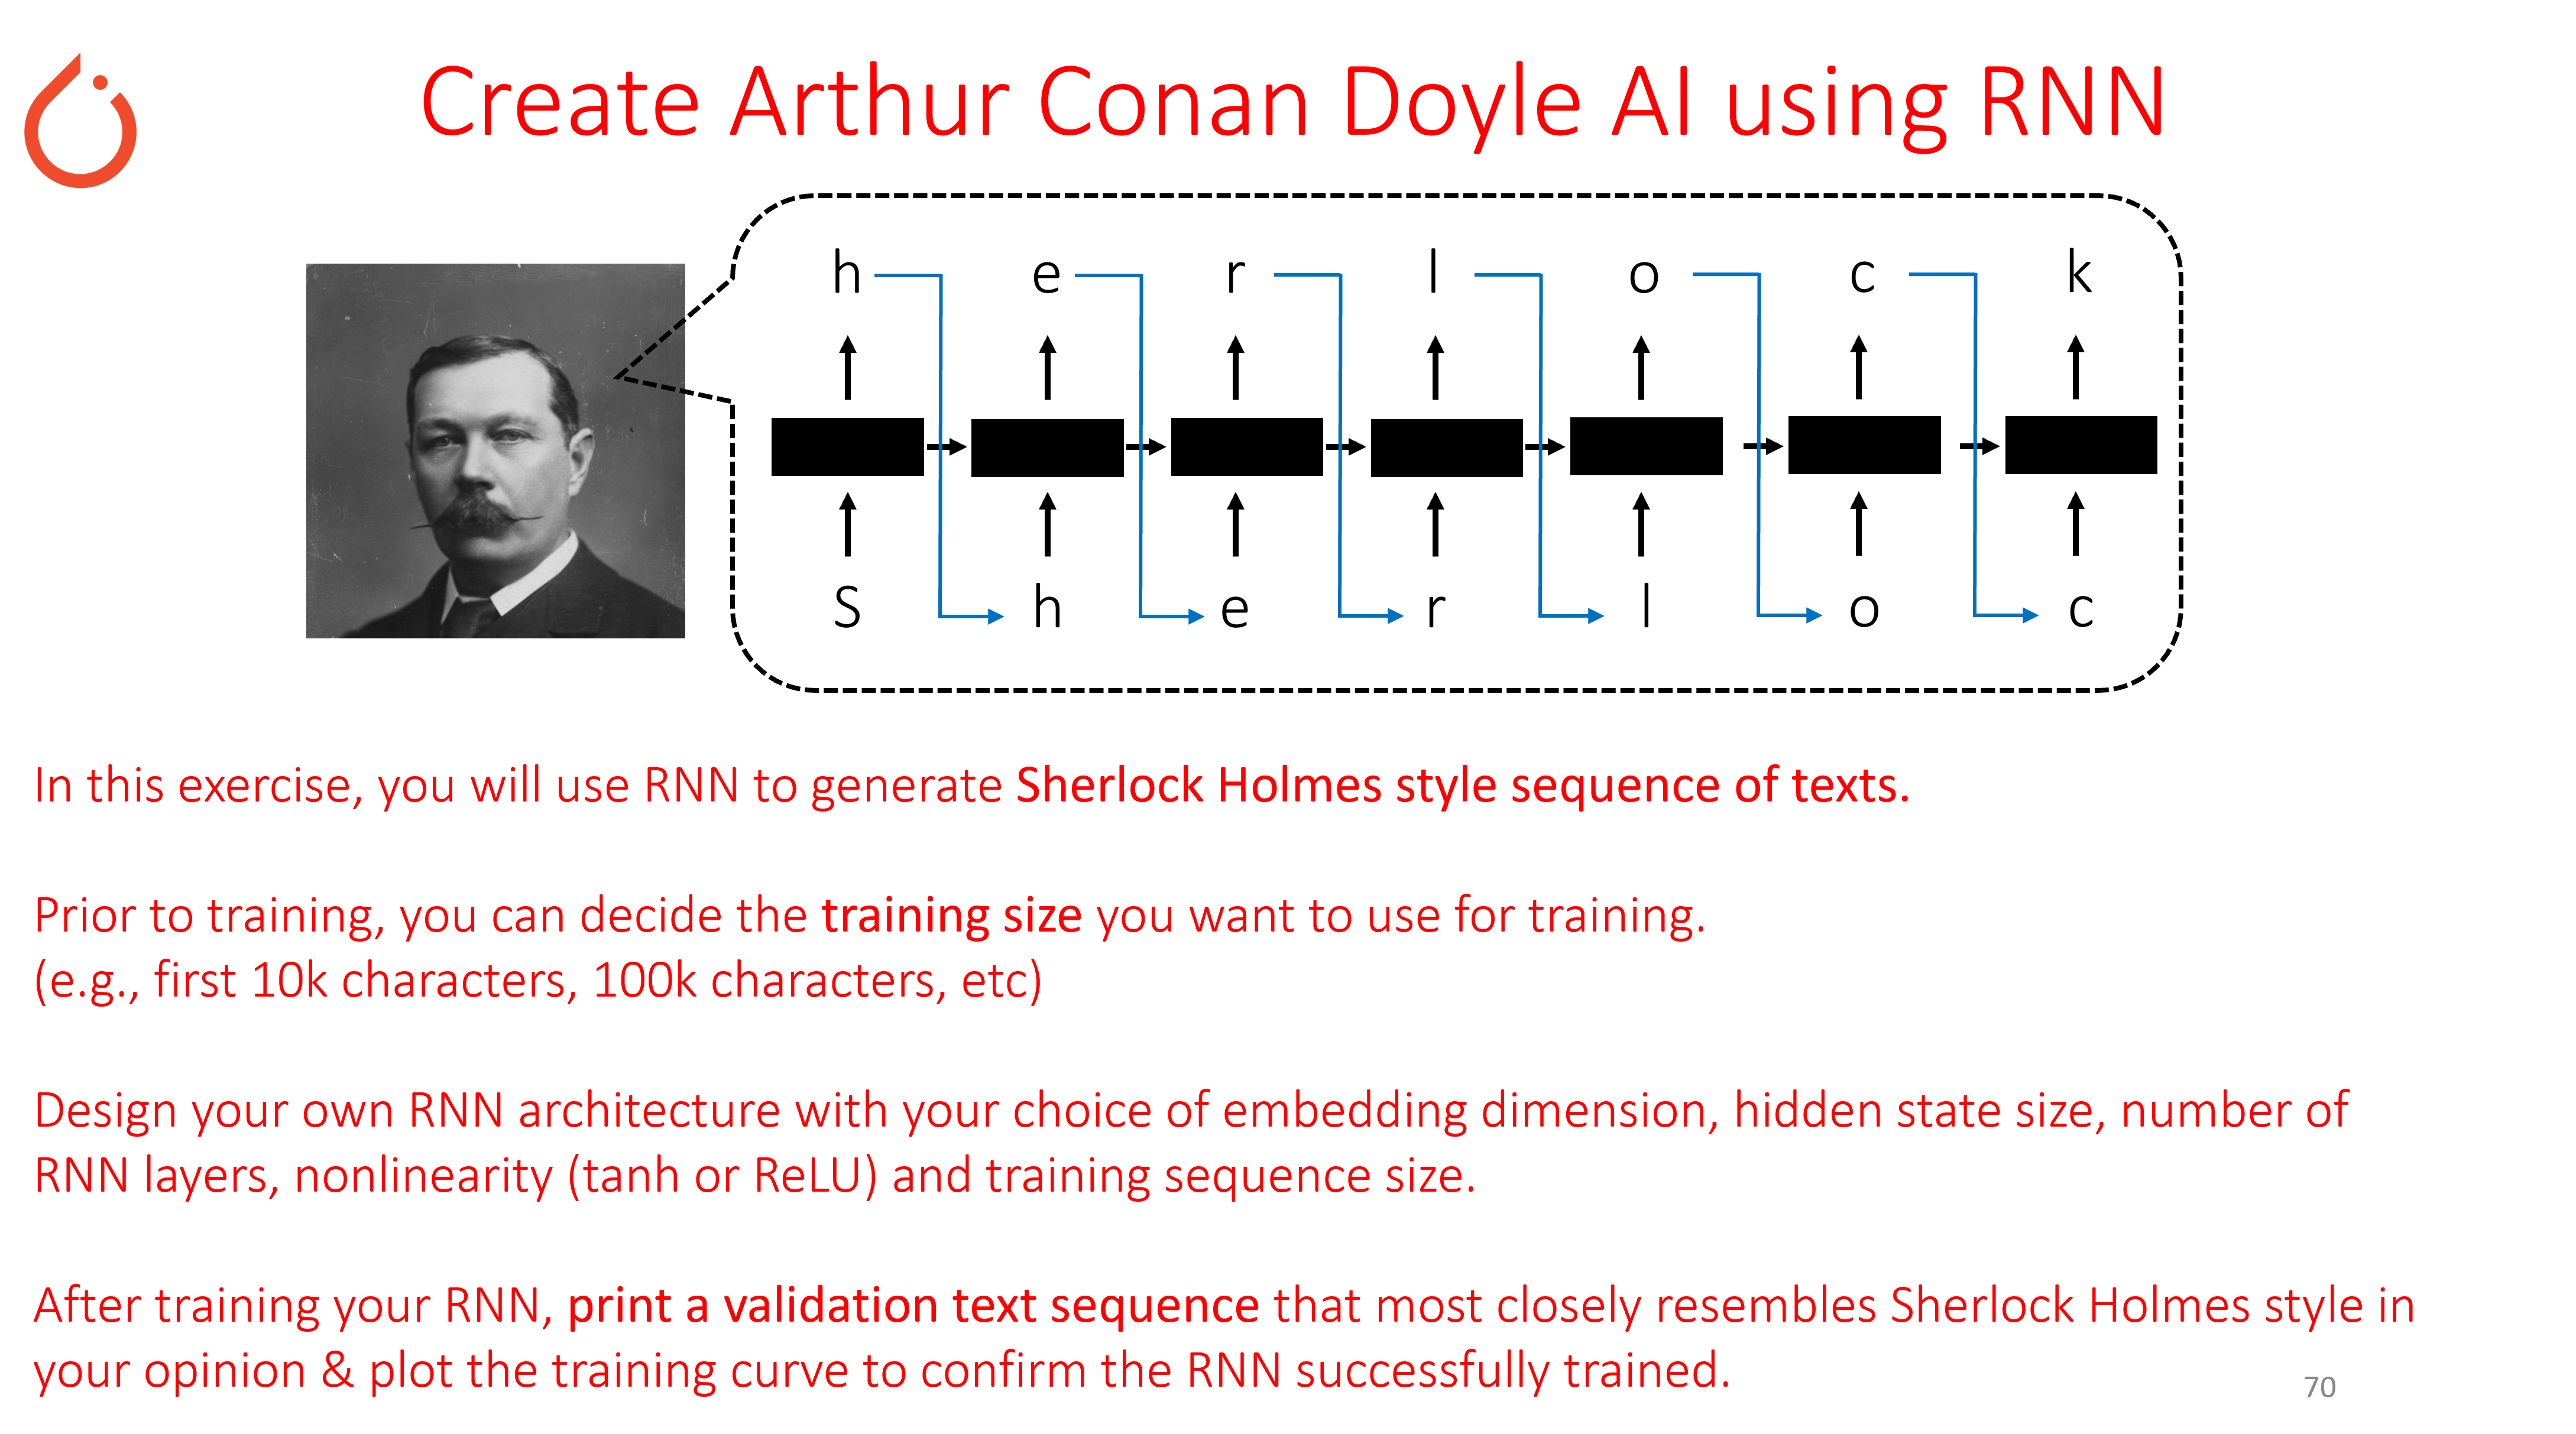

In [59]:
Image('lab5_exercise.png', width = 1000)

## Prepare Data

In [60]:
# First n-characters to use for training
data_size_to_train = 10000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock.txt','r').read()[10000:10000+data_size_to_train]

# Find the unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 10000 characters, 59 unique


In [61]:
# Use Python Dictionary to map the characters to numbers and vice versa

character_to_num = { ch:i for i,ch in enumerate(characters) }
num_to_character = { i:ch for i,ch in enumerate(characters) }


In [62]:
print(character_to_num)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, ',': 5, '-': 6, '.': 7, '1': 8, '2': 9, ';': 10, '?': 11, 'A': 12, 'B': 13, 'C': 14, 'D': 15, 'E': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'R': 27, 'S': 28, 'T': 29, 'V': 30, 'W': 31, 'Y': 32, 'a': 33, 'b': 34, 'c': 35, 'd': 36, 'e': 37, 'f': 38, 'g': 39, 'h': 40, 'i': 41, 'j': 42, 'k': 43, 'l': 44, 'm': 45, 'n': 46, 'o': 47, 'p': 48, 'q': 49, 'r': 50, 's': 51, 't': 52, 'u': 53, 'v': 54, 'w': 55, 'x': 56, 'y': 57, 'z': 58}


In [63]:
# Use the character_to_num dictionary to map each character in the training dataset to a number

data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

In [64]:
# Print first 10 characters represented as numbers 

print(data[:100])

[39, 37, 52, 1, 47, 46, 1, 55, 41, 52, 40, 1, 40, 41, 45, 5, 3, 1, 40, 37, 1, 51, 33, 41, 36, 10, 1, 3, 20, 1, 43, 46, 47, 55, 0, 1, 46, 47, 52, 40, 41, 46, 39, 1, 45, 47, 50, 37, 1, 47, 38, 1, 40, 41, 45, 1, 52, 40, 33, 46, 1, 20, 1, 40, 33, 54, 37, 1, 44, 37, 33, 50, 46, 37, 36, 1, 38, 50, 47, 45, 1, 45, 37, 37, 52, 41, 46, 39, 1, 40, 41, 45, 1, 47, 35, 35, 33, 51, 41, 47]


## Define Model

In [65]:
class CharRNN(torch.nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):
        
        super(CharRNN, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
        
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers,nonlinearity = 'relu')
        
        self.decoder = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        
        embedding = self.embedding(input_seq)
        
        output, hidden_state = self.rnn(embedding, hidden_state)
        
        output = self.decoder(output)
        
        return output, hidden_state.detach()

## Define Hyperparameters

In [66]:
# Fix random seed
torch.manual_seed(25)
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define RNN network
rnn = CharRNN(num_embeddings = vocab_size, embedding_dim = 100, 
              input_size = 100, hidden_size = 1024, num_layers = 3,
              output_size = vocab_size)

# Define learning rate and epochs
learning_rate = 0.001
epochs = 50

# Size of the input sequence to be used during training and validation
training_sequence_len = 50 
validation_sequence_len = 500

# Define loss function and optimizer
loss_fn = loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# add .cuda() for GPU acceleration
rnn.to(device)

CharRNN(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 1024, num_layers=3)
  (decoder): Linear(in_features=1024, out_features=59, bias=True)
)

## Identify Tracked Values

In [67]:
# Tracking training loss per each input/target sequence fwd/bwd pass
train_loss_list = []

## Train Model

In [68]:
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
# Attach .cuda() if using GPU
data = torch.unsqueeze(torch.tensor(data), dim = 1).to(device)

# Training Loop ----------------------------------------------------------------------------------------------------------
for epoch in range(epochs):
    # Randomly select a starting character from first 100 characters in training set
    character_loc = np.random.randint(100)
    # iteration number to keep track of until the sequence reaches the end of training data
    iteration = 0
    
    # initialize initial hidden state as None
    hidden_state = None
    while character_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data
        
        # Define input/target sequence
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]
        
        # Move input_seq and hidden_state to GPU if available
        input_seq = input_seq.to(device)
        if hidden_state is not None:
            hidden_state = hidden_state.to(device)
        
        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)

        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq.to(device)))
        
        # Append loss
        train_loss_list.append(loss.item())
        
        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update starting character for next sequence
        character_loc += training_sequence_len
        
        # Update iteration number
        iteration += 1
            
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))
    
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------
    
# Initialize character location and hidden state for validation
character_loc = 0
hidden_state = None
    
    # Pick a random character from the dataset as an initial input to RNN 
rand_index = np.random.randint(data_size-1)
input_seq = data[rand_index : rand_index+1]

print("----------------------------------------")

with torch.no_grad():
        
    while character_loc < validation_sequence_len:  # Loop continues until RNN generated sequence is in desired length
            
            # Move input_seq and hidden_state to GPU if available
        input_seq = input_seq.to(device)
        if hidden_state is not None:
            hidden_state = hidden_state.to(device)
            
            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
        output, hidden_state = rnn(input_seq, hidden_state)
            
            # Take the softmax of the decoder output to get the probabilities of predicted characters
        output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            
            # Use the probabilities to sample the output character
        character_distribution = torch.distributions.Categorical(output)
        character_num = character_distribution.sample()
            
            # Convert the character number selected from sampling to actual character and print
        print(num_to_character[character_num.item()], end='')
            
            # Update the input_seq so that it's using the output of the RNN as new input
        input_seq[0][0] = character_num.item()
            
            # Update the character location 
        character_loc += 1
print("\n----------------------------------------")


Averaged Training Loss for Epoch  0 :  2.810016804604075
Averaged Training Loss for Epoch  1 :  2.2255118384433152
Averaged Training Loss for Epoch  2 :  2.0004253158665666
Averaged Training Loss for Epoch  3 :  1.8234511458094995
Averaged Training Loss for Epoch  4 :  1.6638812097636135
Averaged Training Loss for Epoch  5 :  1.537079181936052
Averaged Training Loss for Epoch  6 :  1.4183483303491793
Averaged Training Loss for Epoch  7 :  1.3098836466295636
Averaged Training Loss for Epoch  8 :  1.2135131289862624
Averaged Training Loss for Epoch  9 :  1.100600124609591
Averaged Training Loss for Epoch  10 :  1.0389729965871304
Averaged Training Loss for Epoch  11 :  0.9629566223178078
Averaged Training Loss for Epoch  12 :  0.8623985953704275
Averaged Training Loss for Epoch  13 :  0.8116501999560313
Averaged Training Loss for Epoch  14 :  0.7568601727785178
Averaged Training Loss for Epoch  15 :  0.710839568213983
Averaged Training Loss for Epoch  16 :  0.6616221908668075
Averaged Tr

## Visualize & Evaluate Model

In [69]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

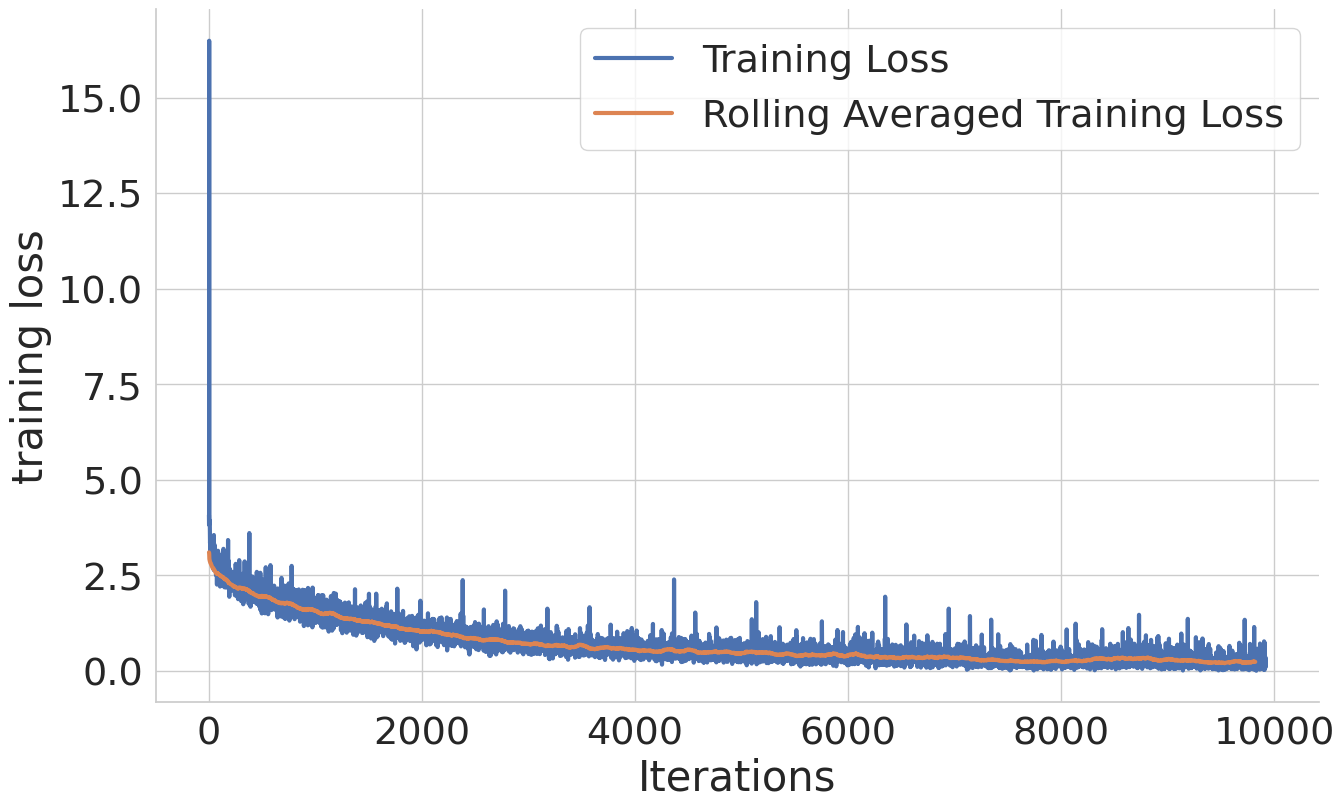

In [70]:
# Plot the training loss and rolling mean training loss with respect to iterations
plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()